In [1]:
from PIL import Image
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import torch
from torch import nn
from torch import optim
from torch import tensor
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from sklearn.manifold import TSNE
import warnings
import torch.nn.functional as F
from math import ceil
from copy import deepcopy
import cv2
import PIL.Image
import sys
from IPython.display import Image
from tqdm import tqdm
import math
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

### 1. Loading Dataset and Dividing to Train-Test Splits

In [2]:
class FaceDataset():
    def __init__(self, t_h, t_w, PATH="/kaggle/input/augumented-dataset/Augmented_LFW_final/Augmented_LFW_Final") -> None:
        self.path = PATH
        self.label = os.listdir(self.path)
        
        self.sz = 0
        
        self.cat_l = []
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((t_h, t_w)),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        for i in self.label:
            tmp = len(os.listdir(os.path.join(self.path, i)))
            self.sz += tmp
            self.cat_l.append(tmp)
        
        
    def __len__(self) -> int:
        return self.sz
    
    def __getitem__(self, idx : int):
        t_idx = idx
        cat_i = 0
        for i in range(len(self.cat_l)):
            if self.cat_l[i] > t_idx:
                cat_i = i
                break
            else:
                t_idx -= self.cat_l[i]
        
        path_t = os.path.join(self.path, self.label[cat_i])
        qtf = os.listdir(path_t)[t_idx]
        img = cv2.imread(os.path.join(path_t, qtf))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                      
        return self.transform(img).numpy(), cat_i

In [3]:
st = FaceDataset(32, 32)

In [4]:
ct = FaceDataset(32, 32, PATH="/kaggle/input/custom-dataset/Custom_Dataset")

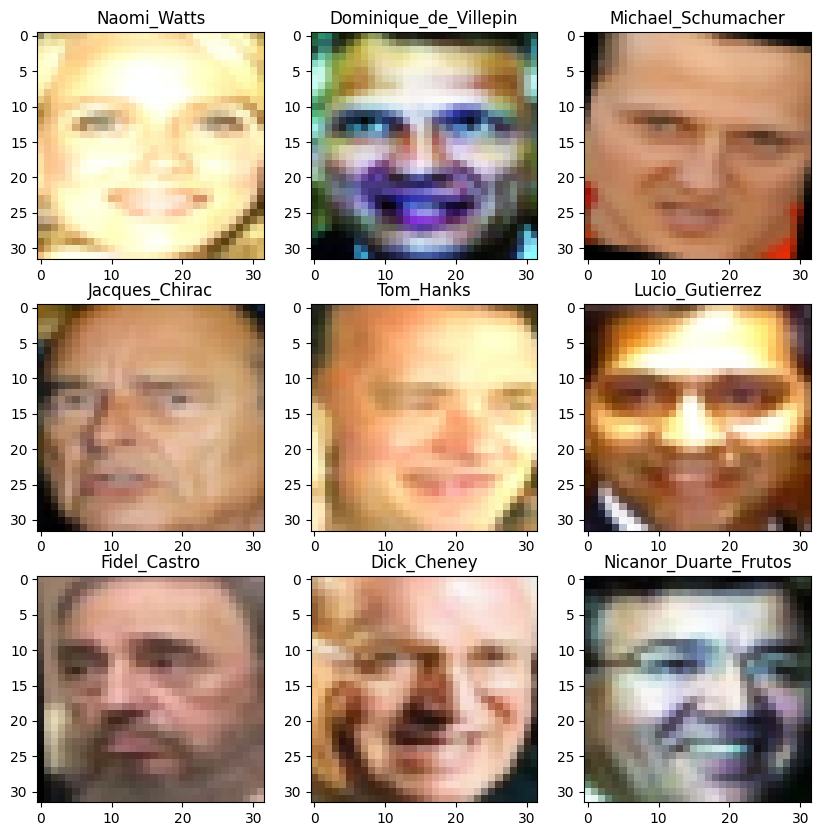

In [5]:
idx_l = [np.random.randint(len(st)) for i in range(9)]

std = [0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(len(idx_l)):
    axes[i//3, i%3].imshow(st[idx_l[i]][0].transpose(1, 2, 0) * std + mean)
    axes[i//3, i%3].set_title(st.label[st[idx_l[i]][1]])

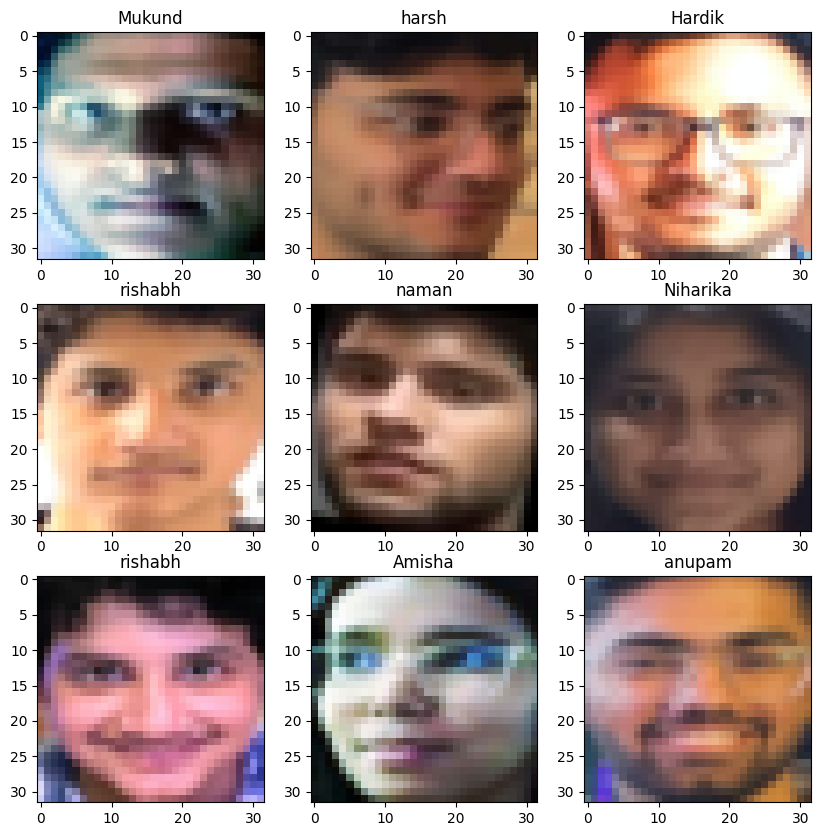

In [6]:
idx_l = [np.random.randint(len(ct)) for i in range(9)]

std = [0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(len(idx_l)):
    axes[i//3, i%3].imshow(ct[idx_l[i]][0].transpose(1, 2, 0) * std + mean)
    axes[i//3, i%3].set_title(ct.label[ct[idx_l[i]][1]])

In [7]:
train_split = 0.80
val_split = 0.10
test_split = 0.10

num_samples = len(st)
num_train = int(train_split * num_samples)
num_val = int(val_split * num_samples)
num_test = num_samples - num_train - num_val

indices = list(range(num_samples))
np.random.shuffle(indices)
strain_indices = indices[:num_train]
sval_indices = indices[num_train:num_train + num_val]
stest_indices = indices[num_train + num_val:]

In [8]:
train_split = 0.80
val_split = 0.10
test_split = 0.10

num_samples = len(ct)
num_train = int(train_split * num_samples)
num_val = int(val_split * num_samples)
num_test = num_samples - num_train - num_val

indices = list(range(num_samples))
np.random.shuffle(indices)
ctrain_indices = indices[:num_train]
cval_indices = indices[num_train:num_train + num_val]
ctest_indices = indices[num_train + num_val:]

### 2. Implementation of  PCA Algorithm.

In [9]:
def asColumnMatrix(X):
    if len(X) == 0:
        return np.array([])
    total = 1
    for i in range(0, np.ndim(X[0])):
        total = total * X[0].shape[i]
    mat = np.empty([total, 0], dtype=X[0].dtype)
    for col in X:
        mat = np.append(mat, col.reshape(-1,1), axis=1) # same as hstack
    return np.asmatrix(mat)


In [10]:
class PCA:
    def __init__(self, num_components=0):
        self._num_components = num_components
        
    def __call__(self, X):

        XC = asColumnMatrix(X)
        #y = np.asarray(y)

        if self._num_components <= 0 or (self._num_components > XC.shape[1]-1):
            self._num_components = XC.shape[1]-1

        self._mean = XC.mean(axis=1).reshape(-1,1)
        XC = XC - self._mean

        self._eigenvectors, self._eigenvalues, variances = np.linalg.svd(XC, full_matrices=False)

        idx = np.argsort(-self._eigenvalues)
        self._eigenvalues, self._eigenvectors = self._eigenvalues[idx], self._eigenvectors[:,idx]

        self._eigenvectors = self._eigenvectors[0:,0:self._num_components].copy()
        self._eigenvalues = self._eigenvalues[0:self._num_components].copy()
        self._eigenvalues = np.power(self._eigenvalues,2) / XC.shape[1]
        features = []
        for x in X:
            xp = self.project(x.reshape(-1,1))
            features.append(xp)
        return features
    
    def extract(self,X):
        X = np.asarray(X).reshape(-1,1)
        return self.project(X)
        
    def project(self, X):
        X = X - self._mean
        return np.dot(self._eigenvectors.T, X)

    def reconstruct(self, X):
        X = np.dot(self._eigenvectors, X)
        return X + self._mean

    @property
    def num_components(self):
        return self._num_components

    @property
    def eigenvalues(self):
        return self._eigenvalues
        
    @property
    def eigenvectors(self):
        return self._eigenvectors

    @property
    def mean(self):
        return self._mean
        
    def __repr__(self):
        return "PCA (num_components=%d)" % (self._num_components)

In [11]:
pca = PCA(num_components=50)

In [12]:
pca_features = pca(np.array([st[i][0] for i in strain_indices]))

In [13]:
pca_features = np.concatenate([i.T for i in pca_features], axis=0)

In [14]:
pca_features.shape

(2726, 50)

In [15]:
tpca_features = pca(np.array([st[i][0] for i in stest_indices]))

In [16]:
tpca_features = np.concatenate([i.T for i in tpca_features], axis=0)

In [17]:
tpca_features.shape

(342, 50)

In [18]:
y_train = np.array([st[i][1] for i in strain_indices]).flatten()
y_test = np.array([st[i][1] for i in stest_indices]).flatten()

In [19]:
y_train

array([26, 16, 38, ..., 17, 10, 15])

In [20]:
accuracy = []
for i in range(1, 25):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(np.asarray(pca_features), y_train)

    test_predict = classifier.predict(np.asarray(tpca_features))

    true_predicted_count=0
    for j in range(0,342):
        if test_predict[j] == y_test[j]:
            true_predicted_count+=1
    accuracy.append((true_predicted_count/342)*100)

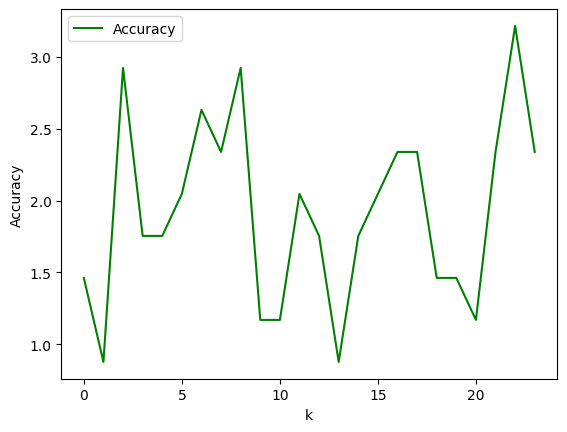

In [21]:
plt.plot(accuracy, c = 'green', label = 'Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(np.asarray(pca_features), y_train)

test_predict = classifier.predict(np.asarray(tpca_features))


In [23]:
accuracy = accuracy_score(y_test, test_predict) * 100.0
overall_precision = precision_score(y_test, test_predict, average='weighted')
overall_recall = recall_score(y_test, test_predict, average='weighted')
overall_f1 = f1_score(y_test, test_predict, average='weighted')

In [24]:
print(f'Overall Accuracy: {accuracy:.3f}%')
print(f'Overall Precision: {overall_precision:.3f}')
print(f'Overall Recall: {overall_recall:.3f}')
print(f'Overall F1-Score: {overall_f1:.3f}')


Overall Accuracy: 1.170%
Overall Precision: 0.008
Overall Recall: 0.012
Overall F1-Score: 0.008


In [25]:
pca = PCA(num_components=50)

In [26]:
pca_features = pca(np.array([st[i][0] for i in ctrain_indices]))

In [27]:
pca_features = np.concatenate([i.T for i in pca_features], axis=0)

In [28]:
tpca_features = pca(np.array([st[i][0] for i in ctest_indices]))

In [29]:
tpca_features = np.concatenate([i.T for i in tpca_features], axis=0)

In [30]:
y_train = np.array([st[i][1] for i in ctrain_indices]).flatten()
y_test = np.array([st[i][1] for i in ctest_indices]).flatten()

In [31]:
accuracy = []
for i in range(1, 25):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(np.asarray(pca_features), y_train)

    test_predict = classifier.predict(np.asarray(tpca_features))

    true_predicted_count=0
    for j in range(0,283):
        if test_predict[j] == y_test[j]:
            true_predicted_count+=1
    accuracy.append((true_predicted_count/342)*100)

IndexError: index 34832 is out of bounds for axis 0 with size 2252

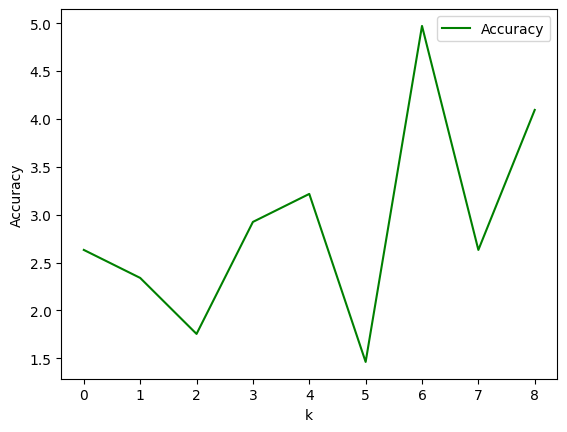

In [32]:
plt.plot(accuracy, c = 'green', label = 'Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
classifier = KNeighborsClassifier(n_neighbors=6)
classifier.fit(np.asarray(pca_features), y_train)

test_predict = classifier.predict(np.asarray(tpca_features))


In [34]:
accuracy = accuracy_score(y_test, test_predict) * 100.0
overall_precision = precision_score(y_test, test_predict, average='weighted')
overall_recall = recall_score(y_test, test_predict, average='weighted')
overall_f1 = f1_score(y_test, test_predict, average='weighted')

In [35]:
print(f'Overall Accuracy: {accuracy:.3f}%')
print(f'Overall Precision: {overall_precision:.3f}')
print(f'Overall Recall: {overall_recall:.3f}')
print(f'Overall F1-Score: {overall_f1:.3f}')

Overall Accuracy: 2.827%
Overall Precision: 0.028
Overall Recall: 0.028
Overall F1-Score: 0.024
